In [85]:
import requests
import json
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.forecasting.stl import STLForecastResults
from statsmodels.tsa.arima.model import ARIMA

# Load APP_TOKEN vairable from keys file
from secret import APP_TOKEN

# Table of contents
* [Overview](#Overview)
* [Data](#Data)
* [Model](#Model)

## Overview

The purpose of this project is to create a model to predict the number of crimes that might occur in some chicago neighborhood on any given day. We will be using the Chicago Crimes Dataset, limiting ourselves to the date and community area fields from this set of data. 


## Data <a name="Data"></a>

In [2]:
url = "https://data.cityofchicago.org/resource/ijzp-q8t2.json?$select=date,community_area&$where=year<=2020 AND year >= 2010&$order=date ASC&$limit=10000000"
headers = {'Accept': 'application/json', 'X-App-Token': APP_TOKEN}
resp = requests.get(url,headers=headers)
df = json.loads(resp.text)
df = pd.DataFrame(df)
df

,date,community_area
0,2010-01-01T00:00:00.000,11
1,2010-01-01T00:00:00.000,15
2,2010-01-01T00:00:00.000,16
3,2010-01-01T00:00:00.000,2
4,2010-01-01T00:00:00.000,61
...,...,...
3184593,2020-12-31T23:45:00.000,69
3184594,2020-12-31T23:45:00.000,38
3184595,2020-12-31T23:45:00.000,32
3184596,2020-12-31T23:51:00.000,29


In [3]:
# Data pre-processing: Trasforming data to the the total number of crimes occured each day per community area

# Make a copy of the queried data
df_new = df
# The exact time of crime occured is not necessary, we only keep date data
df_new['date'] = df_new['date'].str[:10]
# count rows that have the same value, this will give us number of crimes for that community_area for a certain day
df_new = df_new.groupby(df.columns.tolist(), as_index=False).size()
# rename columns
df_new.rename({'size': 'num_crimes'}, axis=1, inplace=True)

# convert to date type
df_new['date'] = pd.to_datetime(df_new['date'])

df_new

,date,community_area,num_crimes
0,2010-01-01,1,25
1,2010-01-01,10,2
2,2010-01-01,11,9
3,2010-01-01,12,2
4,2010-01-01,13,6
...,...,...,...
297621,2020-12-31,75,8
297622,2020-12-31,76,2
297623,2020-12-31,77,7
297624,2020-12-31,8,11


We will be creating visualizations of the data using the cumulative crime data for the city, as we will be able to detect seasonality from a city wide standpoint. Our time series analysis will proceed using cumulative data based on the month, as it would be very tricky to work with day to day seasonality.

In [4]:
# total crimes for the entire city per month
df_total_month = df_new
# convert month column into useable format
df_total_month['month'] = df_total_month['date'].dt.to_period('M')
# group number of crimes by month
df_total_month = df_total_month.groupby(df_total_month['month'], as_index=False).size()

#Set the index
df_total_month.set_index('month',inplace=True)
df_total_month.index = df_total_month.index.to_timestamp()

df_total_month

,size
month,
2010-01-01,2321
2010-02-01,2090
2010-03-01,2319
2010-04-01,2256
2010-05-01,2330
...,...
2020-08-01,2276
2020-09-01,2203
2020-10-01,2280


In [5]:
# Plot the number of crimes for the entire city per calendar month
fig = px.line(df_total_month, y="size")
fig.show()

From our preliminary plot, there appears to be a strong component of seasonality in our data and it does not appear to be multiplicative. As a result, we run a naive seasonal decomposition using an additive model.

<AxesSubplot:xlabel='month'>

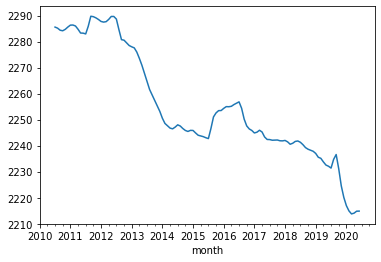

In [6]:
# display seasonal decomposition charts using the statsmodels package
result = seasonal_decompose(df_total_month["size"],  model='additive')
# plotting trend (seasonally adjusted)
result.trend.plot()

<AxesSubplot:xlabel='month'>

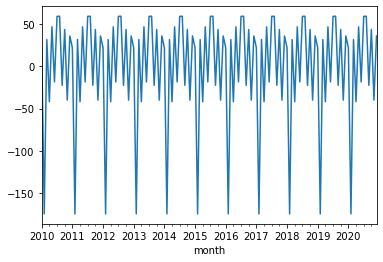

In [7]:
result.seasonal.plot()

count    120.000000
mean      -0.300694
std       16.561686
min      -66.100694
25%       -7.921528
50%       -0.213194
75%        8.330556
max       85.578472
Name: resid, dtype: float64

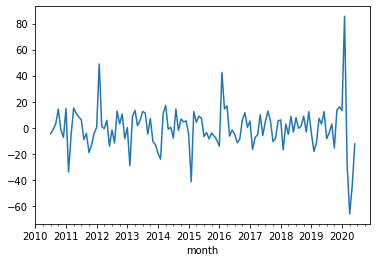

In [8]:
result.resid.plot()
result.resid.describe()

## Model <a name="Model"></a>

A naive seasonal decomposition reveals that the trend componenet of our data is not exactly linear. The mean of our residuals is approximately zero, suggesting that trend information captured by the seasonal decomposition is mostly accurate. Given the results of our exploratory analysis, running a seasonal decomposition using loess might prove successful, and an ARIMA model could be used to provide forecasting results. 

<AxesSubplot:xlabel='month'>

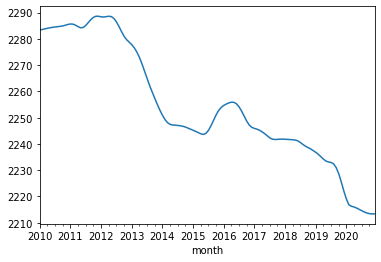

In [9]:
# run STL decomposition, seasonal attribute is set to 13 because of we are using montly data
stl = STL(df_total_month, seasonal = 13)
res = stl.fit()

# STL trend plot
res.trend.plot()

The trend of our STL decomposition is much smoother than a naive seasonal decompostion

<AxesSubplot:xlabel='month'>

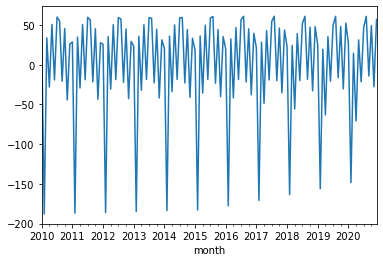

In [10]:
# STL seasonal plot
res.seasonal.plot()

count    132.000000
mean       0.011125
std       13.724279
min      -39.042638
25%       -6.469145
50%        0.165467
75%        6.002711
max       59.667085
Name: resid, dtype: float64

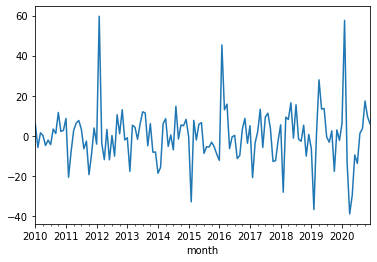

In [11]:
# STL residuals plot
res.resid.plot()
res.resid.describe()

The mean of the residuals of our STL decomposition are closer to zero now, the STL has given us less error overall. We now perform the Augmented Dickey Fuller (ADF) test to see if our timeseries is stationary.

In [12]:
# ADF test
def adfuller_test(some_ts):
    res = adfuller(some_ts)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value, label in zip(res, labels):
        print(label+' : '+str(value) )

adfuller_test(df_total_month['size'])

ADF Test Statistic : -0.31832847696051203
p-value : 0.9228680590286752
#Lags Used : 12
Number of Observations : 119


The ADF test shows that our time series is not stationary, in fact it is far from it, with a p-value of .92. We will have to manually determine the parameters for our ARIMA model. 

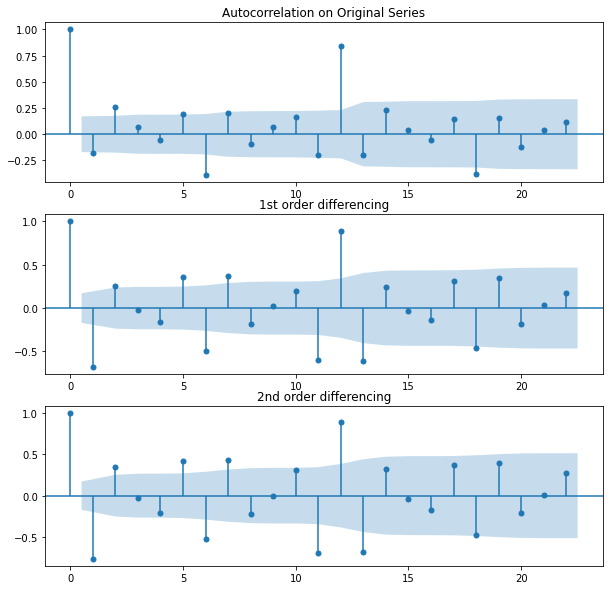

In [13]:
# finding order of differencing using auto correlation
fig = plt.figure(figsize = (10 ,10))

ax1 = fig.add_subplot(311)
fig = plot_acf(df_total_month, ax=ax1, title="Autocorrelation on Original Series")

ax2 = fig.add_subplot(312)
fig = plot_acf(df_total_month.diff().dropna(), ax=ax2, title="1st order differencing")

ax3 = fig.add_subplot(313)
fig = plot_acf(df_total_month.diff().diff().dropna(), ax=ax3, title="2nd order differencing")

Increasing the autoregressive terms seems to only increase the amount of lags above the significance level. We will progress with d = 0.

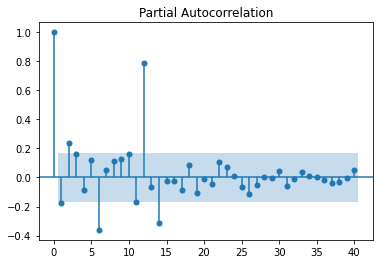

In [14]:
# Partial auto correction using d = 0
fig = plot_pacf(df_total_month, method='ywm', lags=40)

Two lags are significantly about the significance level. We will use p = 2.

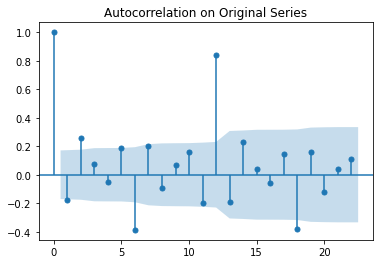

In [15]:
# Autocorrelation
fig = plot_acf(df_total_month, title="Autocorrelation on Original Series")

Two lags are found to be above the significance level, and so q = 2. Out ARIMA parameters will be p = 2, d = 0, and q = 2.

Lets generate some results based on past data and see how effective our model is.

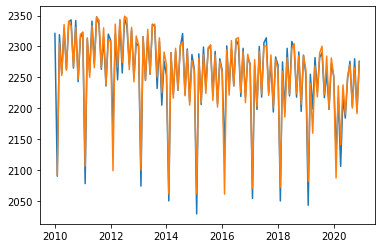

In [152]:
# Turn data frame into series so that we can work with get_prediction method
df_total_month_series = df_total_month.squeeze()

# Use STL to remove seasonalities and ARIMA to predict
stlf = STLForecast(df_total_month_series, ARIMA, model_kwargs=dict(order=(2,0,2), trend='t'))
stlf_res = stlf.fit()

# Generate predictions starting at index 1 until the most recent month
preds = stlf_res.get_prediction(start=df_total_month_series.index[1],end=df_total_month_series.index[-1])
plt.plot(df_total_month)
plt.plot(preds.predicted_mean)
plt.show()

Finally, we perform some forecasting using our model.

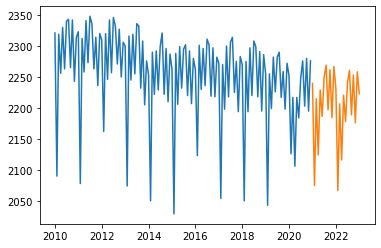

In [51]:
# Use STL to remove seasonalities and ARIMA to forecast
stlf = STLForecast(df_total_month, ARIMA, model_kwargs=dict(order=(2,0,2), trend='t'))
stlf_res = stlf.fit()

# Generate forcast for n periods
forecast = stlf_res.forecast(25)
plt.plot(df_total_month)
plt.plot(forecast)
plt.show()

In [20]:
print(stlf_res.summary())

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                  132
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -545.383
Date:                Thu, 01 Jul 2021   AIC                           1102.766
Time:                        18:26:52   BIC                           1120.063
Sample:                    01-01-2010   HQIC                          1109.795
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -2.0197    4.1e-05  -4.93e+04      0.000      -2.020      -2.020
ar.L1          2.0000   9.96e-06   2.01e+05      0.000       2.000       2.000
ar.L2         -1.0000   9.85e-06  -1.01e+05      0.0

In [27]:
print(forecast)

2021-01-01    2239.741224
2021-02-01    2074.933761
2021-03-01    2214.906697
2021-04-01    2124.145526
2021-05-01    2228.811098
2021-06-01    2186.172602
2021-07-01    2249.062364
2021-08-01    2269.093096
2021-09-01    2197.272200
2021-10-01    2261.594600
2021-11-01    2184.397131
2021-12-01    2266.752917
2022-01-01    2231.562787
2022-02-01    2066.734371
2022-03-01    2206.686343
2022-04-01    2115.904197
2022-05-01    2220.548782
2022-06-01    2177.889288
2022-07-01    2240.758041
2022-08-01    2260.767754
2022-09-01    2188.925826
2022-10-01    2253.227184
2022-11-01    2176.008662
2022-12-01    2258.343383
2023-01-01    2223.132177
Freq: MS, dtype: float64
